# COVID-19 Global Analysis – Insights

This notebook derives country-level insights from the cleaned COVID-19 dataset, 
focusing on exploratory analysis, vaccination coverage, fatality ratios, and a 
compact comparison of selected countries.

In [ ]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True

ROOT_DIR = Path.cwd().parent
if str(ROOT_DIR) not in sys.path:
    sys.path.append(str(ROOT_DIR))

from src.config import PROCESSED_DATA_DIR, COVID_CLEAN_FEATURES_PATH

In [2]:
clean_path = COVID_CLEAN_FEATURES_PATH

df_clean = pd.read_csv(clean_path)

if "date" in df_clean.columns and not np.issubdtype(df_clean["date"].dtype, np.datetime64):
    df_clean["date"] = pd.to_datetime(df_clean["date"], errors="coerce")

print("Clean dataset loaded.")
print(f"Shape: {df_clean.shape[0]:,} rows x {df_clean.shape[1]} columns")

df_clean.head()

Clean dataset loaded.
Shape: 155,331 rows x 72 columns


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,new_cases_pm_7d_avg,new_deaths_pm_7d_avg,stringency_index_7d_avg,case_fatality_ratio,vaccination_coverage
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,0.511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,0.511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,0.511,NaN,NaN,NaN,NaN,0.0420,NaN,8.33,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,0.511,NaN,NaN,NaN,NaN,0.0315,NaN,8.33,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,0.511,NaN,NaN,NaN,NaN,0.0252,NaN,8.33,NaN,NaN


In [3]:
required_cols = ["location", "date"]
missing_cols = [c for c in required_cols if c not in df_clean.columns]
if missing_cols:
    raise KeyError(f"Missing required columns: {missing_cols}")

df_clean = df_clean.sort_values(["location", "date"])

latest_per_country = (
    df_clean
    .groupby("location", as_index=False)
    .tail(1)
    .reset_index(drop=True)
)

print(f"Number of countries: {latest_per_country['location'].nunique()}")
latest_per_country[["location", "date"]].head()

Number of countries: 223


,location,date
0,Afghanistan,2022-03-05
1,Albania,2022-03-05
2,Algeria,2022-03-05
3,Andorra,2022-03-05
4,Angola,2022-03-05



Top 10 countries by total_cases_per_million:


,location,total_cases_per_million
66,Faeroe Islands,706541.904
3,Andorra,496858.598
54,Denmark,490811.590
77,Gibraltar,463298.804
181,Slovenia,434278.160
171,San Marino,425962.952
74,Georgia,407981.058
180,Slovakia,401998.616
176,Seychelles,398614.902
97,Israel,394910.343


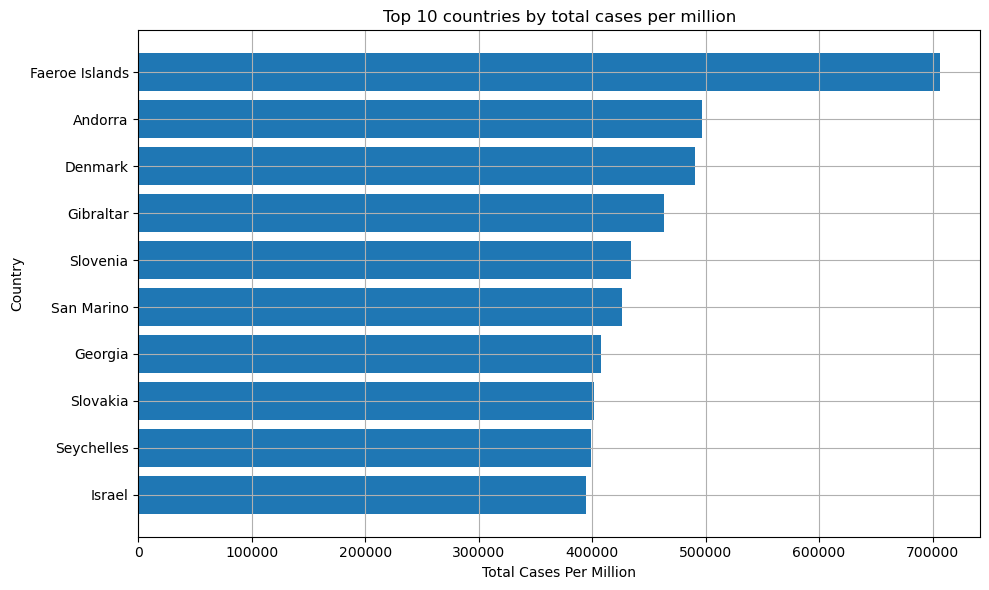


Top 10 countries by total_deaths_per_million:


,location,total_deaths_per_million
156,Peru,6322.263
30,Bulgaria,5192.517
25,Bosnia and Herzegovina,4755.384
89,Hungary,4596.767
147,North Macedonia,4357.406
132,Montenegro,4275.131
74,Georgia,4105.259
48,Croatia,3722.508
52,Czechia,3626.445
180,Slovakia,3424.862


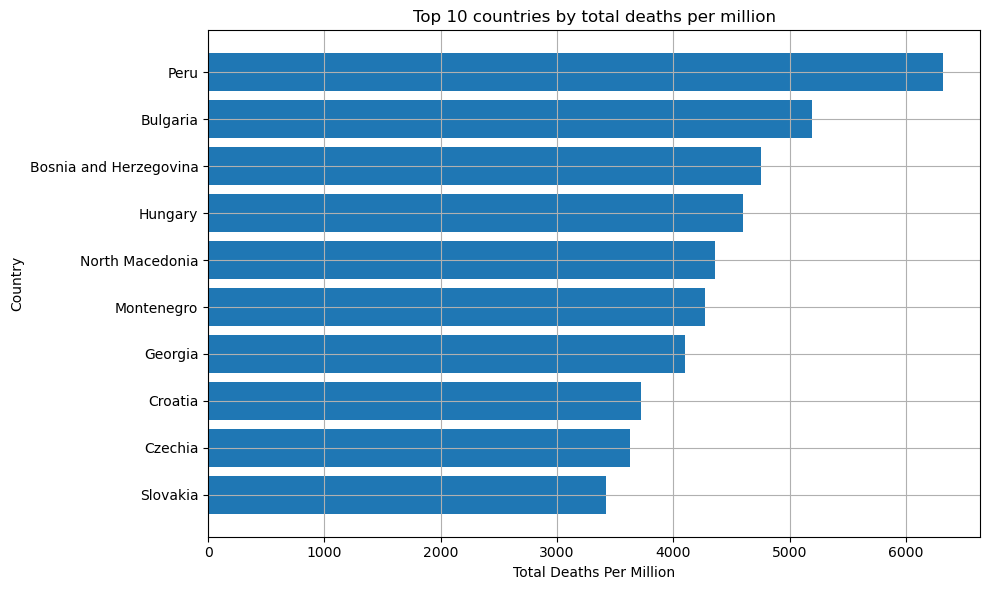

In [4]:
metrics = [
    "total_cases_per_million",
    "total_deaths_per_million",
]

for metric in metrics:
    if metric not in latest_per_country.columns:
        print(f"Metric '{metric}' is not available in the dataset.")
        continue

    top10 = latest_per_country.nlargest(10, metric)[["location", metric]].copy()
    print(f"\nTop 10 countries by {metric}:")
    display(top10)

    plt.figure(figsize=(10, 6))
    top10_sorted = top10.sort_values(metric, ascending=True)
    plt.barh(top10_sorted["location"], top10_sorted[metric])
    plt.title(f"Top 10 countries by {metric.replace('_', ' ')}")
    plt.xlabel(metric.replace("_", " ").title())
    plt.ylabel("Country")
    plt.tight_layout()
    plt.show()

Number of countries with non-null CFR: 204
Mean CFR:  0.0153
Median CFR: 0.0114


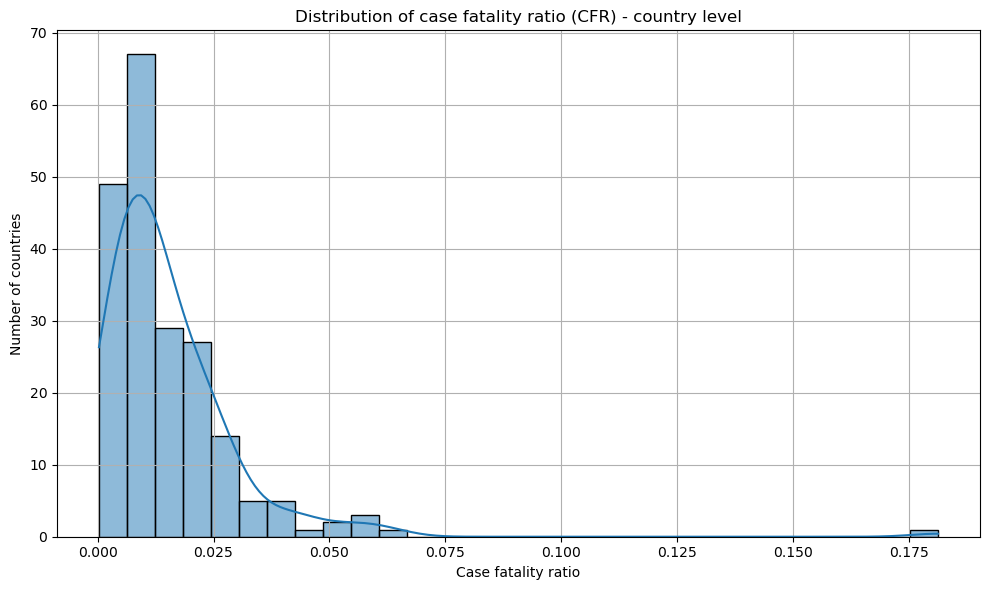

In [5]:
if "case_fatality_ratio" not in latest_per_country.columns:
    raise KeyError("Column 'case_fatality_ratio' is missing from the dataset.")

cfr = latest_per_country["case_fatality_ratio"].dropna()

cfr_filtered = cfr[(cfr >= 0) & (cfr <= 0.2)]

print(f"Number of countries with non-null CFR: {cfr.shape[0]}")
print(f"Mean CFR:  {cfr.mean():.4f}")
print(f"Median CFR: {cfr.median():.4f}")

plt.figure(figsize=(10, 6))
sns.histplot(cfr_filtered, bins=30, kde=True)
plt.title("Distribution of case fatality ratio (CFR) - country level")
plt.xlabel("Case fatality ratio")
plt.ylabel("Number of countries")
plt.tight_layout()
plt.show()

Number of countries in vaccination vs CFR analysis: 36


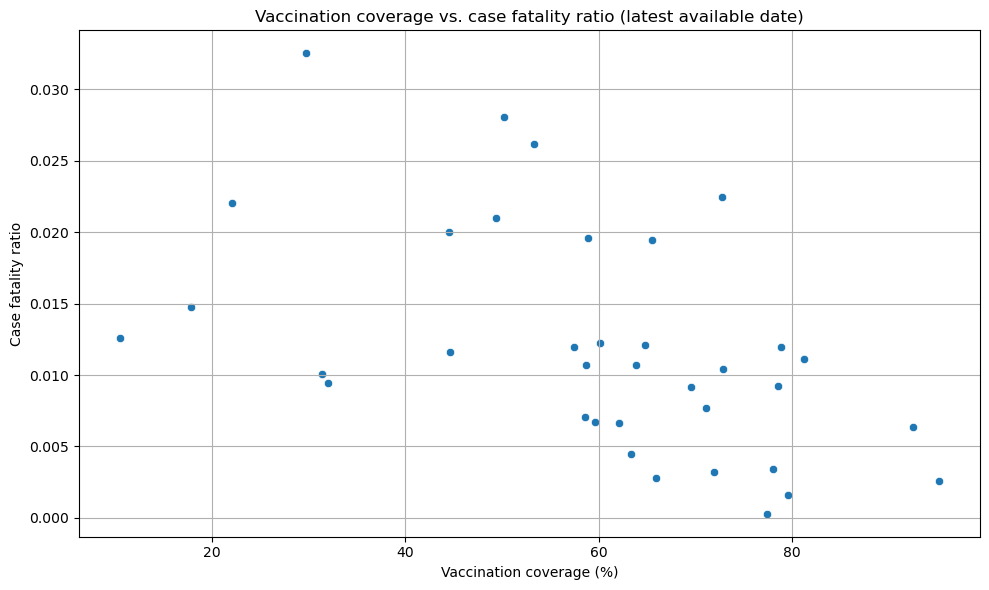

Pearson correlation between vaccination coverage and CFR: -0.4990


In [10]:
required_cols = ["vaccination_coverage", "case_fatality_ratio"]
missing = [c for c in required_cols if c not in latest_per_country.columns]
if missing:
    raise KeyError(f"Missing required columns for analysis: {missing}")

mask = (
    latest_per_country["vaccination_coverage"].notna()
    & latest_per_country["case_fatality_ratio"].notna()
)

df_model = latest_per_country.loc[mask].copy()

print(f"Number of countries in vaccination vs CFR analysis: {df_model.shape[0]}")

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_model,
    x="vaccination_coverage",
    y="case_fatality_ratio",
)
plt.title("Vaccination coverage vs. case fatality ratio (latest available date)")
plt.xlabel("Vaccination coverage (%)")
plt.ylabel("Case fatality ratio")
plt.tight_layout()
plt.show()

corr = df_model[["vaccination_coverage", "case_fatality_ratio"]].corr().iloc[0, 1]
print(f"Pearson correlation between vaccination coverage and CFR: {corr:.4f}")

## Country-level case studies

In this section we focus on a selected group of European countries and Turkey:
Italy, Turkey, Germany, Switzerland, Spain, France, and the United Kingdom.
We compare their COVID-19 dynamics over time using cases, deaths and vaccination coverage.


In [17]:
focus_countries = [
    "Italy",
    "Turkey",
    "Germany",
    "Switzerland",
    "Spain",
    "France",
    "United Kingdom",
]

latest_focus = latest_per_country.loc[
    latest_per_country["location"].isin(focus_countries)
].copy()

summary_cols = [
    "location",
    "total_cases_per_million",
    "total_deaths_per_million",
    "case_fatality_ratio",
    "vaccination_coverage",
]

summary_focus = latest_focus[summary_cols].copy()

summary_focus["total_cases_per_million"] = summary_focus[
    "total_cases_per_million"
].round(0)
summary_focus["total_deaths_per_million"] = summary_focus[
    "total_deaths_per_million"
].round(0)
summary_focus["case_fatality_ratio_pct"] = (
    summary_focus["case_fatality_ratio"] * 100
).round(2)
summary_focus["vaccination_coverage"] = summary_focus["vaccination_coverage"].round(1)

summary_focus

,location,total_cases_per_million,total_deaths_per_million,case_fatality_ratio,vaccination_coverage,case_fatality_ratio_pct
70,France,342096.0,2066.0,0.006040,NaN,0.60
75,Germany,188677.0,1479.0,0.007840,NaN,0.78
98,Italy,215186.0,2581.0,0.011992,78.8,1.20
187,Spain,237467.0,2148.0,0.009046,NaN,0.90
192,Switzerland,331659.0,1512.0,0.004558,NaN,0.46
204,Turkey,168459.0,1122.0,0.006658,62.2,0.67
211,United Kingdom,281086.0,2377.0,0.008458,NaN,0.85


In [18]:
def plot_metric_bar(
    df: pd.DataFrame,
    metric_col: str,
    title: str,
    xlabel: str,
    figsize: tuple[int, int] = (8, 5),
) -> None:
    
    if metric_col not in df.columns:
        raise KeyError(f"Column '{metric_col}' is not in the dataframe.")

    data = df.sort_values(metric_col, ascending=True)

    plt.figure(figsize=figsize)
    plt.barh(data["location"], data[metric_col])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Country")

    for i, v in enumerate(data[metric_col]):
        plt.text(
            v,
            i,
            f" {v}",
            va="center",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()

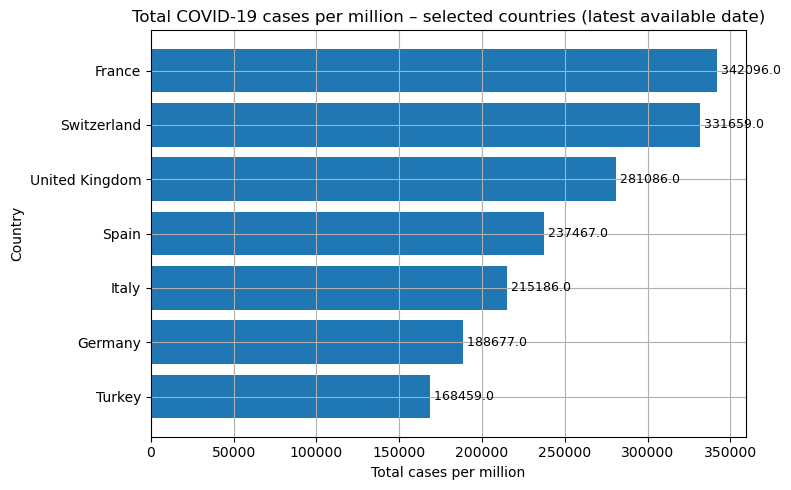

In [19]:
plot_metric_bar(
    df=summary_focus,
    metric_col="total_cases_per_million",
    title="Total COVID-19 cases per million – selected countries (latest available date)",
    xlabel="Total cases per million",
)

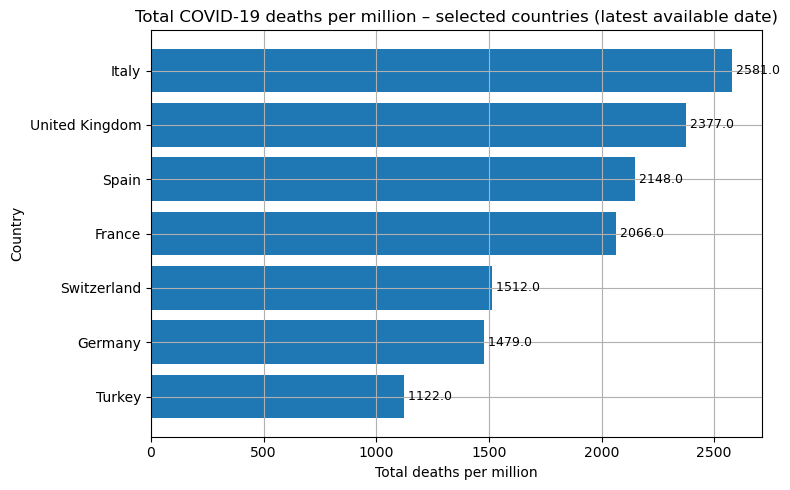

In [20]:
plot_metric_bar(
    df=summary_focus,
    metric_col="total_deaths_per_million",
    title="Total COVID-19 deaths per million – selected countries (latest available date)",
    xlabel="Total deaths per million",
)

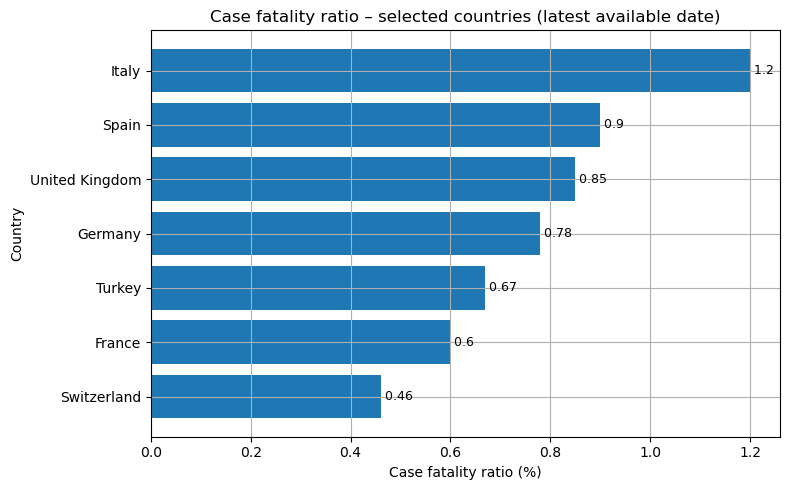

In [21]:
plot_metric_bar(
    df=summary_focus,
    metric_col="case_fatality_ratio_pct",
    title="Case fatality ratio – selected countries (latest available date)",
    xlabel="Case fatality ratio (%)",
)

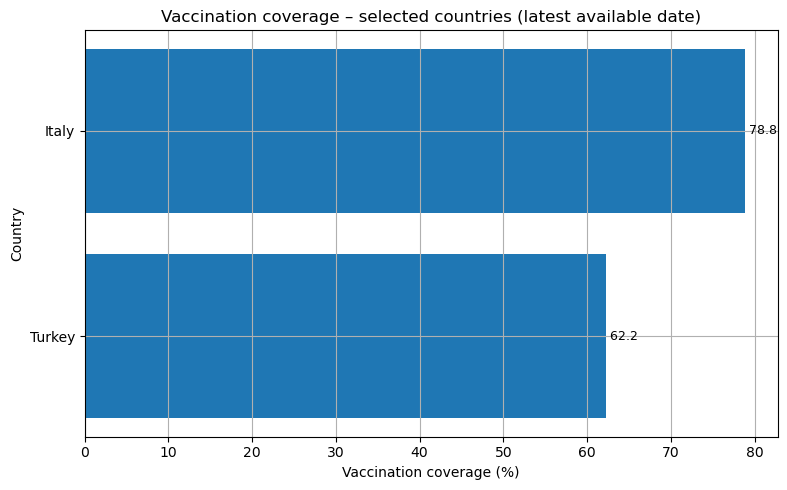

In [22]:
plot_metric_bar(
    df=summary_focus,
    metric_col="vaccination_coverage",
    title="Vaccination coverage – selected countries (latest available date)",
    xlabel="Vaccination coverage (%)",
)

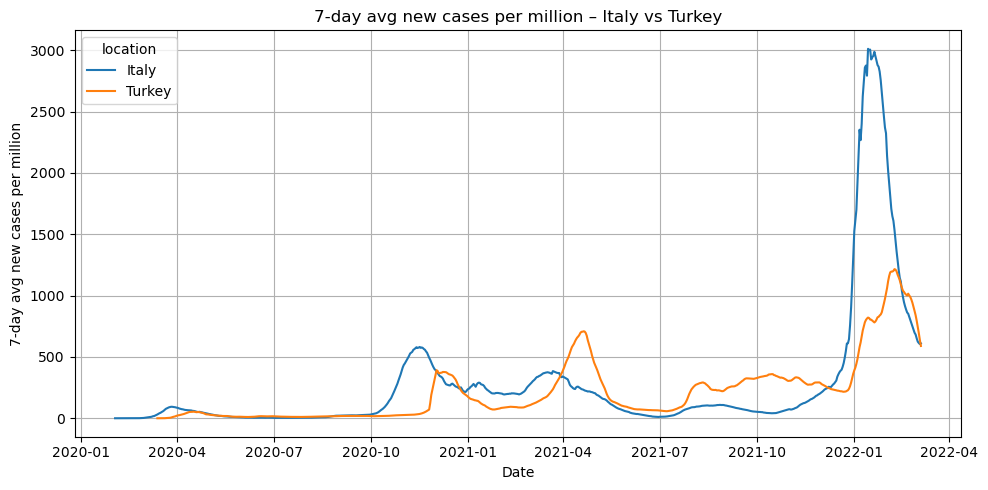

In [23]:
pair_countries = ["Italy", "Turkey"]

df_pair = (
    df_clean.loc[df_clean["location"].isin(pair_countries)]
    .copy()
    .sort_values(["location", "date"])
)

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_pair,
    x="date",
    y="new_cases_pm_7d_avg",
    hue="location",
)
plt.title("7-day avg new cases per million – Italy vs Turkey")
plt.xlabel("Date")
plt.ylabel("7-day avg new cases per million")
plt.tight_layout()
plt.show()

## COVID-19 Global Analysis – Summary of Findings

This project explores the Our World in Data (OWID) COVID-19 dataset with a focus on:

    -Global patterns in cases, deaths and fatality ratios

    -The relationship between vaccination coverage and case fatality ratio (CFR)

    -A compact comparison of seven countries that are highly relevant for my network:
     Italy, Turkey, Germany, Switzerland, Spain, France and the United Kingdom

All analysis is based on country-level data, after:

    -Removing aggregate OWID entries (e.g. OWID_WRL, OWID_EUR, income groups)

    -Cleaning obvious anomalies (negative daily values set to missing, safe datetime conversion)

    -Engineering rolling 7-day averages and simple ratios (e.g. CFR, vaccination coverage)